# Sample NLCD

In [1]:
import rasterio as rio
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import earthpy.spatial as es
import random

In [3]:
ma_nlcd = rxr.open_rasterio("data/raw/NLCD_MA_2016.tif").squeeze()
ma_crs = es.crs_check("data/raw/NLCD_MA_2016.tif")

In [4]:
ma_nlcd.shape

(6169, 10004)

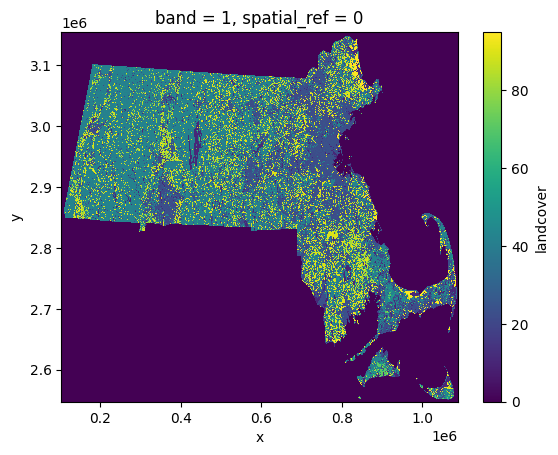

In [5]:
f, ax = plt.subplots()
ma_nlcd.plot.imshow(ax=ax)
plt.show()

In [6]:
ma_nlcd.shape, ma_crs

((6169, 10004),
 CRS.from_wkt('PROJCS["NAD83 / Massachusetts Mainland (ftUS)",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",41],PARAMETER["central_meridian",-71.5],PARAMETER["standard_parallel_1",42.6833333333333],PARAMETER["standard_parallel_2",41.7166666666667],PARAMETER["false_easting",656166.667],PARAMETER["false_northing",2460625],UNIT["US survey foot",0.304800609601219,AUTHORITY["EPSG","9003"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2249"]]'))

In [7]:
ma = rio.open("data/raw/NLCD_MA_2016.tif")

In [8]:
maval = ma.read(1)
type(maval)

numpy.ndarray

In [9]:
maval[0:50, 0:50]
np.any(np.isnan(maval))

np.False_

In [10]:
np.unique(maval)

array([ 0, 11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95],
      dtype=uint8)

In [11]:
np.prod(maval.shape), np.sum(maval.flatten() == 0), np.prod(maval.shape) - np.sum(maval.flatten() == 0)

(np.int64(61714676), np.int64(38072131), np.int64(23642545))

In [12]:
float(np.sum(maval.flatten() == 0)) / float(np.prod(maval.shape)), 1600 / 30 * 6

(0.6169056287356998, 320.0)

## Sampling Plan
We want to mimic the sample design of the NRI data. The NRI sampling design is the following:
1. Divide land into townships (6mi x 6mi)
2. For each township partition the area into Sections (1mi x 1mi)
3. From each township choose quarter sections from each Section such that no there is only one quarter section chosen from each row and column of each township, no selected quarter sections are adjacent to each other, and only one quarter section is selected from each section.
4. From each quarter section, select three points using the restricted randomization procedure.

In this design, we take 36 square miles, select one square mile,
and then select three spatially balanced points within the square mile. This is how we intend to do this:
1. Divide the original image into squares with side lengths of 360 pixels (at a 30m resolution this is slightly larger
than 6 miles a side).
2. Remove squares with more than 5% of the pixels equal to "0".
3. In the remaining squares select six quarter sections of 15 by 15 pixels according to a balanced sample design.
    - First, select six sections such that each section is from a unique column and row.
    - Then randomly select a quarter section from each selected section.
4. In each selected quarter section, select three pixels according to a spatially balanced design.
    - Select one pixel from the top third, one pixel from the middle third and one pixel from the bottom third such that each selected pixel is
   contained within its own column third (left, middle, or center).

For the NLCD data townships are 360 x 360 pixels, sections are 60 x 60 pixels and quarter sections are 15 x 15 pixels.

In [40]:
def get_spread_cols(num_cols, allow_diag=False):
    avail_cols = [i for i in range(num_cols)]
    col_ind = [random.choice(avail_cols)]
    avail_cols = list(set(avail_cols).difference(set(col_ind)))
    r = 1
    while r < num_cols:
        count = 0
        while len(col_ind) < r + 1:
            count = count + 1
            # Randomly select available column
            col = random.choice(avail_cols)
            # print(f"col is {col}")
            # Check if diagonal
            if abs(col - col_ind[r - 1]) != 1 or allow_diag:
                col_ind.append(col)
                avail_cols = list(set(avail_cols).difference(set(col_ind)))
            if count == num_cols * 2:
                r = 1
                avail_cols = [i + 1 for i in range(num_cols)]
                col_ind = [random.choice(avail_cols)]
                avail_cols = list(set(avail_cols).difference(set(col_ind)))
        r = r + 1
                
    return(col_ind)

get_spread_cols(6), get_spread_cols(3, True)

([5, 2, 4, 1, 3, 0], [1, 2, 0])

In [30]:
def get_base_coord(sq_size, block_size, block):
    """
    Args:
        sq_size: The total number of pixels in a row (or column) in the full image
        block_size: The total number of pixels in a row (or column) in a block
        block: The number of the block. Blocks are numbered like in the following:
        |---|---|---|
        | 0 | 1 | 2 |
        |---|---|---|
        | 3 | 4 | 5 |
        |---|---|---|
        | 6 | 7 | 8 |
        |---|---|---|
    """
    total_blocks_in_col = sq_size / block_size
    base_j = (block % total_blocks_in_col) * block_size
    base_i = (block // total_blocks_in_col) * block_size
    return base_i, base_j

def get_ij_coord(sq_size, block_size, row_i, col_j):
    """
    Args:
        sq_size: The total number of pixels in a row (or column) in the full image
        block_size: The total number of pixels in a row (or column) in a block
        block: The indices of the block. Blocks are numbered like:
        |-----|-----|-----|
        | 0,0 | 0,1 | 0,2 |
        |-----|-----|-----|
        | 1,0 | 1,1 | 1,2 |
        |-----|-----|-----|
        | 2,0 | 2,1 | 2,2 |
        |-----|-----|-----|
    """
    total_blocks_in_col = sq_size / block_size
    base_i = row_i * block_size
    base_j = col_j * block_size
    return base_i, base_j
    

In [31]:
total_blocks_in_col = 3
block = 6
block % total_blocks_in_col, block // total_blocks_in_col

blocks = random.sample([i for i in range(9)], 3)
block_base = [get_base_coord(15, 5, b) for b in blocks]
i = random.choice([i for i in range(5)])
j = random.choice([i for i in range(5)])
blocks, block_base, i, j, block_base[0][0] + i, block_base[0][1] + j
get_ij_coord(15, 5, 1, 0)

(5, 0)

In [35]:
col_vec = get_spread_cols(3, True)
i = random.choice([i for i in range(5)])
j = random.choice([i for i in range(5)])
base_lst = [get_ij_coord(15, 5, r_ind, c_ind) for (r_ind, c_ind) in zip([1, 2, 3], col_vec)]
base_lst, i, j

([(5, 15), (10, 10), (15, 5)], 4, 4)

In [36]:
[(base_r + i, base_c + j) for (base_r, base_c) in base_lst]

[(9, 19), (14, 14), (19, 9)]

In [37]:
def get_points():
    col_vec = get_spread_cols(3, True)
    i = random.choice([i for i in range(5)])
    j = random.choice([i for i in range(5)])
    base_lst = [get_ij_coord(15, 5, r_ind, c_ind) for (r_ind, c_ind) in zip([1, 2, 3], col_vec)]
    return([(base_r + i, base_c + j) for (base_r, base_c) in base_lst])
    
get_points()

[(7, 13), (12, 18), (17, 8)]

In [43]:
def sample_township(lab, i_start, j_start):

    # Step 1: Get Sections, Quarter-Sections, and Points to sample
    # This gives us the section block positions (r, c)
    sec_cols = get_spread_cols(6) 
    # TODO: We need to convert to section base coordinates
    sec_coords = [get_ij_coord(360, 60, base_r, base_c) for (base_r, base_c) in zip([0, 1, 2, 3, 4, 5], sec_cols)]
    # This gives us the quarter section block positions (r, c)
    quart_secs = [random.choice([0, 1, 2, 3]) for i in range(6)]
    # This converts block positions to quarter section base coordinates
    qs_coords = [get_base_coord(60, 15, quarter_sec_num) for quarter_sec_num in quart_secs]
    # This gives the coordinates for each point within a quarter section.
    points = get_points()

    coords_lst = []
    qsec_lab = []
    pt_lab = []
    for (sec_r, sec_c) in sec_coords:
        for (qs_r, qs_c) in quart_secs:
            for (pt_r, pt_c) in points:
                coords_lst.append([(i_start + sec_r + qs_r + pt_r, j_start + sec_c + qs_c + pt_c)])
                qsec_lab.append([f"S{sec_r}{sec_c}Q{qs_r}{qs_c}"])
                pt_lab.append([f"P{pt_r}{pt_c}"])

    return(coords_lst, qsec_lab, pt_lab)
    
    # We want to return a dataframe with the following information for each point:
    # - Township label: lab
    # - Section label: Sij
    # - Point label: {1, 2, 3}
    # - Pixel value: TBD (get later)
    # - Original x coordinate
    # - Original y coordinate
    # - Latitude: TBD (get later)
    # - Longitude: TBD (get later)

sample_township("test", 0, 0)

TypeError: cannot unpack non-iterable int object

In [29]:
15 * 15 / 3

75.0

In [127]:
secs = {1, 2, 3, 4}.difference({random.choice([1, 2, 3, 4])})
secs

{1, 2, 3}

In [140]:
random.sample([i for i in range(9)], 3)

[8, 1, 2]